Infrastructure based on:
https://s3.us-west-2.amazonaws.com/montemac.share/probing_main.html

We want to use probes on each channel


In [1]:
# Imports
%reload_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np
import pandas as pd
import scipy as sp
from sklearn.feature_selection import f_classif
import torch as t
import torch.nn.functional as f
import xarray as xr
import plotly.express as px
import plotly as py
import plotly.subplots
import plotly.graph_objects as go
from einops import rearrange, repeat
from IPython.display import Video, display
from tqdm.auto import tqdm
import warnings

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import circrl.rollouts as cro
import circrl.probing as cpr

import procgen_tools.models as models
import procgen_tools.maze as maze

warnings.filterwarnings("ignore", message=r'.*labels with no predicted samples.*')

# Hack to make sure cwd is the script folder
os.chdir(globals()['_dh'][0])

import procgen_tools
import matplotlib.pyplot as plt
from procgen_tools.imports import *
from procgen_tools import visualization, maze, vfield, patch_utils



building procgen...done


In [2]:
# Number of mazes to work with

num_batch = 200

In [3]:
# Functions

# Takes in a maze object, position in maze, venv (collection of environments), and returns labels regarding whether the position contains object
def is_obj_in_pos(obj, pos, venv):
    square_is_obj = []

    for env_idx in range(venv.num_envs):
        #maze.EnvState(dd[state_bytes_key])

        square_is_obj.append(maze.state_from_venv(venv, env_idx).full_grid()[pos] == obj)

    square_is_obj = np.array(square_is_obj, dtype=bool)
    return square_is_obj

# Train sparse linear probes on observation of model as a baseline

def test_probes_on_obs( obj_is_in_pos_array, hook_to_use, index_nums = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    results, _ = cpr.sparse_linear_probe(hook_to_use, ['embedder.block1.conv_in0'], obj_is_in_pos_array, 
        index_nums=index_nums, random_state=42, class_weight='balanced', max_iter=1000, C=10.)
    #px.line(x=index_nums, y=results.score.isel(value_label=0)).show()
    x = pd.DataFrame({'num_activations': index_nums, 'test_score': results.score.isel(value_label=0).values}).set_index('num_activations')
    print(x)

# Plot the sparse probe scores
def plot_sparse_probe_scores(results, y, index_nums, title, include_limits=True):
    scores_df = results.score.to_dataframe().reset_index()
    scores_df['K'] = index_nums[scores_df['index_num_step']]
    fig = px.line(scores_df, x='value_label', y='score', color='K', title=title)
    if include_limits:
        fig.add_hline(y=1., line_dash="dot", annotation_text="perfect", annotation_position="bottom right")
        baseline_score = abs(y.mean()-0.5) + 0.5
        fig.add_hline(y=baseline_score, line_dash="dot", annotation_text="baseline", 
                annotation_position="bottom right")
    fig.show()

# Apply probes to various layers in the network
def test_probes_layers(obj_is_in_pos_array, hook_to_use, pos, index_nums = np.array([1, 2, 10, 50, 100]),
    value_labels_to_plot = [
        'embedder.block1.conv_in0',
        'embedder.block1.res1.resadd_out',
        'embedder.block1.res2.resadd_out',
        'embedder.block2.res1.resadd_out',
        'embedder.block2.res2.resadd_out',
        'embedder.block3.res1.resadd_out',
        'embedder.block3.res2.resadd_out']
    ):


    results, _ = cpr.sparse_linear_probe(hook_to_use, value_labels_to_plot, obj_is_in_pos_array,
        index_nums = index_nums, random_state=42, class_weight='balanced', max_iter=10000, C=10.)


    plot_sparse_probe_scores(results, obj_is_in_pos_array, index_nums, 
        f'Probe score over layers and K-values for {pos} "is open"')
    

# Get the probe target for object location
def get_obj_loc_targets(venv, obj_value):
    '''Get potential probe targets for y,x (row, col) location of an
    object, where the object is specified by obj_value as the value
    to match on in the maze grid array.'''
    pos_arr = maze.get_object_pos_from_seq_of_states(
        [maze.state_from_venv(venv, env_idx).state_bytes for env_idx in range(num_batch)], obj_value)
    pos = xr.Dataset({
        'y': xr.DataArray(pos_arr[:,0], dims=['batch']),
        'x': xr.DataArray(pos_arr[:,1], dims=['batch'])}).assign_coords(
            {'batch': np.arange(num_batch)})
    return pos

# Get the probe target for top right corner
def get_top_right_loc_targets(venv):
    '''Get potential probe targets for y,x (row, col) location of an
    object, where the object is specified by obj_value as the value
    to match on in the maze grid array.'''
    # pos_arr is array of length len(state_bytes_seq) with (y,x) locations of object
    # pos_arr = maze.get_object_pos_from_seq_of_states(
    #     [maze.state_from_venv(venv, env_idx).state_bytes for env_idx in range(num_batch)], obj_value)
    # Replace with top right corner coords
    pos_arr = np.array([[maze.state_from_venv(venv,env_idx).inner_grid().shape[0]-1, maze.state_from_venv(venv,env_idx).inner_grid().shape[0]-1] for env_idx in range(num_batch)])
    pos = xr.Dataset({
        'y': xr.DataArray(pos_arr[:,0], dims=['batch']),
        'x': xr.DataArray(pos_arr[:,1], dims=['batch'])}).assign_coords(
            {'batch': np.arange(num_batch)})
    return pos


def euclidian_mouse_dist_to_top_right(grid: np.ndarray) -> float:
    """
    Euclidian distance from (x,y) to the cheese. default heuristic for A*
    """
    #print(grid)
    grid_size = grid.shape[0]
    

    # venv = maze.venv_from_grid(grid)
    # visualization.visualize_venv(
    #     venv
    # )
    cx, cy = maze.get_mouse_pos(grid)
    # print(grid_size-1, grid_size-1)
    # print(cx,cy)
    return np.sqrt((grid_size-1 - cx) ** 2 + (grid_size-1 - cy) ** 2)

def get_mouse_dist_to_top_right(venv):
    '''Get potential probe targets for y,x (row, col) location of an
    object, where the object is specified by obj_value as the value
    to match on in the maze grid array.'''
    #print(euclidian_mouse_dist_to_top_right(maze.state_from_venv(venv, 0).inner_grid()))
    dist = [euclidian_mouse_dist_to_top_right(maze.state_from_venv(venv, env_idx).inner_grid()) for env_idx in range(num_batch)]
    dist_arr = np.array(dist)
    return dist_arr

def visualize_maze(state: maze.EnvState) -> None:
    venv = maze.venv_from_grid(state.inner_grid())
    visualization.visualize_venv(venv, render_padding=False)

# Helper functions for conv probes
# 
# Some helper functions
def grid_coord_to_value_ind(full_grid_coord, value_size):
    '''Pick the value index that covers the majority of the grid coord pixel'''
    # TODO: I'm pretty sure this is the best groudned approach, but ch 55 responds better to the approach in probing_main.py
    return np.floor((full_grid_coord+0.5) * value_size/maze.WORLD_DIM).astype(int)

def value_ind_to_grid_coord(value_ind, value_size):
    '''Pick the grid coordinate index whose center is closest to the center of the value pixel'''
    return np.floor((value_ind+0.5) * maze.WORLD_DIM/value_size).astype(int)

def get_obj_pos_data(value_label, object_pos, hook_to_use):
    '''Pick the object location and a random other location without the object so we have a
    balanced dataset of pixels 2x the original size.'''
    rng = np.random.default_rng(15)
    # TODO: vectorize this!    
    value = hook_to_use.get_value_by_label(value_label)
    value_size = value.shape[-1]
    num_pixels = num_batch * 2
    pixels = np.zeros((num_pixels, value.shape[1]))
    is_obj = np.zeros(num_pixels, dtype=bool)
    rows_in_value = np.zeros(num_pixels, dtype=int)
    cols_in_value = np.zeros(num_pixels, dtype=int)
    for bb in tqdm(range(obs_all.shape[0])):
        # Cheese location (transform from full grid row/col to row/col in this value)
        obj_pos_value = (grid_coord_to_value_ind(
                maze.WORLD_DIM-1 - object_pos.y[bb].item(), value_size),
            grid_coord_to_value_ind(object_pos.x[bb].item(), value_size))
        pixels[bb,:] = value[bb,:,obj_pos_value[0],obj_pos_value[1]]
        is_obj[bb] = True
        rows_in_value[bb] = obj_pos_value[0]
        cols_in_value[bb] = obj_pos_value[1]
        # Random pixel that isn't the object location
        bb_rand = bb + num_batch
        random_pos = obj_pos_value
        while random_pos == obj_pos_value:
            random_pos = (rng.integers(value_size), rng.integers(value_size))
        pixels[bb_rand,:] = value[bb,:,random_pos[0],random_pos[1]]
        is_obj[bb_rand] = False
        rows_in_value[bb_rand] = random_pos[0]
        cols_in_value[bb_rand] = random_pos[1]
    return pixels, is_obj, rows_in_value, cols_in_value

# def show_f_test_results(pixels, target, target_name, rows_in_value, cols_in_value):
#     f_test, _ = cpr.f_classif_fixed(pixels, target)
#     f_test_df = pd.Series(f_test).sort_values(ascending=False)

#     fig = px.line(y=f_test_df, title=f'Sorted {target_name} f-test scores for channels of<br>{value_label}',
#         hover_data={'channel': f_test_df.index})
#     fig.update_layout(
#         xaxis_title="channel rank",
#         yaxis_title="f-test score",)
#     fig.show()

#     print(list(f_test_df.index[:20]))

#     for ch_ind in f_test_df.index[:2]:
#         show_pixel_histogram(pixels, target, target_name, ch_ind)

def make_pixel_data(value_labels, obj_pos, hook_to_use):
    f_test_list = []
    pixel_data = {}
    for value_label in value_labels:
        pixels, is_obj, rows_in_value, cols_in_value = get_obj_pos_data(value_label, obj_pos, hook_to_use)
        f_test, _ = cpr.f_classif_fixed(pixels, is_obj)
        sort_inds = np.argsort(f_test)[::-1]
        pixel_data[value_label] = (pixels, is_obj, rows_in_value, cols_in_value, f_test, sort_inds)
        f_test_list.append(pd.DataFrame(
            {'layer': np.full(sort_inds.shape, value_label), 'rank': np.arange(len(sort_inds)),
            'channel': sort_inds, 'f-score': f_test[sort_inds]}))
        #show_f_test_results(pixels, is_obj, 'cheese', rows_in_value, cols_in_value)
    f_test_df = pd.concat(f_test_list, axis='index')
    return pixel_data, f_test_df
    # px.line(f_test_df, x='rank', y='f-score', color='layer', hover_data=['channel'],
    #     title='Ranked f-test scores for "conv pixel contains cheese" over resadd layers').show()

def plot_linear_probe_score(hook, values_to_store, obj_pos, index_nums, model_name, object_name):

    #Could try with just linear probes instead

    results, _ = cpr.sparse_linear_probe(hook, values_to_store, obj_pos, model_type='ridge',
        index_nums = index_nums, random_state=42, max_iter=10000, alpha=100.)

    plot_sparse_probe_scores(results, obj_pos, index_nums, 
        f'Probe score over layers for: Model = {model_name}, abstraction = {object_name}',
        include_limits=False)



In [34]:
# Generate mazes:
venv = maze.create_venv(num=num_batch, start_level=0, num_levels=0, env_name = "maze" )
AX_SIZE = 2



In [35]:
# Load models:
policy_cheese, hook_cheese = load_model('15', 15)
policy_topright, hook_topright = load_model('1', 15)
# policy_redgem = models.load_policy('logs/train/maze_yellowstar_redgem/2023-08-06__14-42-51/model_10240.pth', 15)
# policy_yellowstar = models.load_policy('logs/train/maze_redgem_yellowstar/2023-08-06__14-42-51/model_10240.pth', 15)
# hook_redgem = cmh.ModuleHook(policy_redgem)
# hook_yellowstar = cmh.ModuleHook(policy_yellowstar)

hook1 = hook_cheese
hook2 = hook_topright

model1_name = 'Cheese Mouse'
model2_name = 'Top Right Mouse'



In [36]:
# Collect activations



values_to_store = [
    'embedder.block1.conv_in0',
    'embedder.block1.res1.relu1_out',
    'embedder.block1.res1.relu2_out',
    'embedder.block1.res1.resadd_out',
    'embedder.block1.res2.relu1_out',
    'embedder.block1.res2.relu2_out',
    'embedder.block1.res2.resadd_out',
    'embedder.block2.res1.relu1_out',
    'embedder.block2.res1.relu2_out',
    'embedder.block2.res1.resadd_out',
    'embedder.block2.res2.relu1_out',
    'embedder.block2.res2.relu2_out',
    'embedder.block2.res2.resadd_out',
    'embedder.block3.res1.relu1_out',
    'embedder.block3.res1.relu2_out',
    'embedder.block3.res1.resadd_out',
    'embedder.block3.res2.relu1_out',
    'embedder.block3.res2.relu2_out',
    'embedder.block3.res2.resadd_out',
    # 'embedder.flatten_out',
    # 'embedder.relufc_out',
    # 'fc_policy_out',
]



# Run obs through model to get all the activations
obs_all = venv.reset().astype('float32')

_ = hook1.run_with_input(obs_all, values_to_store=values_to_store)
_ = hook2.run_with_input(obs_all, values_to_store=values_to_store)


In [38]:
# Get the goal and goal variant positions. Note that this depends on maze type (redgem or yellowstar)
goal_pos = get_obj_loc_targets(venv, 2)
#goal_variant_pos = get_obj_loc_targets(venv, 3)

goal_pos_x = goal_pos.x.values.astype(float)
goal_pos_y = goal_pos.y.values.astype(float)

# goal_variant_pos_x = goal_variant_pos.x.values.astype(float)
# goal_variant_pos_y = goal_variant_pos.y.values.astype(float)





In [39]:
# Calculate linear probe scores

index_nums = np.array([100,1000,100000])

#TO DO: add normal scores, not sparse

plot_linear_probe_score(hook1, values_to_store, goal_pos_x, index_nums, 'Cheese Mouse', 'Cheese')
plot_linear_probe_score(hook2, values_to_store, goal_pos_x, index_nums, 'Top Right Mouse', 'Cheese')





  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [40]:
%%capture
#Make pixel data

pixel_data = {}
f_test_dfs = {}
obj_model_scores = {}

pixel_data[('goal', model1_name)], f_test_dfs['cheese, hook1'] = make_pixel_data(values_to_store, goal_pos, hook1)
pixel_data[('goal', model2_name)], f_test_dfs['cheese, hook2'] = make_pixel_data(values_to_store, goal_pos, hook2)
# pixel_data[('goal variant', model1_name)], f_test_dfs['noobj, hook1'] = make_pixel_data(values_to_store, goal_variant_pos, hook1)
# pixel_data[('goal variant', model2_name)], f_test_dfs['noobj, hook2'] = make_pixel_data(values_to_store, goal_variant_pos, hook2)



In [46]:


# Calculate object-model scores
def calc_obj_model_scores(scores_df, K_value, linear_weighting=True):
    filtered_df = scores_df[scores_df['K'] == 16]

    # Generate linearly interpolated vector
    
    #interpolated_vector = np.linspace(0, 1, n)

    # Multiply the scores by the interpolated vector
    n = len(filtered_df)

    if linear_weighting is True:
        weighted_vector = np.linspace(1, n, n)*2/(n+1)
    else:
        weighted_vector = np.ones(n)

    filtered_df['adjusted_score'] = filtered_df['score'] * weighted_vector

    score = filtered_df['adjusted_score'].sum() / n

    return score

# Train probes and show results

index_nums = np.arange(16)+1

for obj_model_names, pixel_data_this in pixel_data.items():
    scores_list = []
    for value_label, (pixels, is_obj, rows_in_value, cols_in_value, f_test, sort_inds) in tqdm(pixel_data_this.items()):
        for K in index_nums:
            results = cpr.linear_probe(pixels[:,sort_inds[:K]], is_obj, C=10, random_state=42)
            scores_list.append({'layer': value_label, 'K': K, 'score': results['test_score']})
    scores_df = pd.DataFrame(scores_list)

    

    # Calculate object-model score
    linear_weighting=True
    score = calc_obj_model_scores(scores_df, 16, linear_weighting)
    obj_model_scores[obj_model_names] = score



    fig = px.line(scores_df, x='layer', y='score', color='K',
        title=f'Sparse probe scores for "conv pixel contains {obj_model_names[0]}" over layers and K values for {obj_model_names[1]}. Score = {score}.')
    fig.add_hline(y=1.,  line_dash="dot", annotation_text="perfect",  annotation_position="bottom right")
    fig.add_hline(y=0.5, line_dash="dot", annotation_text="baseline", annotation_position="bottom right")
    fig.show()





  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:04<00:00,  4.19it/s]
/tmp/ipykernel_113706/301907806.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100%|██████████| 19/19 [00:04<00:00,  4.45it/s]
/tmp/ipykernel_113706/301907806.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
#Compute softmax of scores

def softmax(arr):
    """Compute softmax values for each element in arr."""
    e_arr = np.exp(arr - np.max(arr))  # subtract max for numerical stability
    return e_arr / e_arr.sum()

softmaxed_scores = softmax(list(obj_model_scores.values()))
obj_model_softmaxed_scores = {key: val for key, val in zip(obj_model_scores.keys(), softmaxed_scores)}

print(obj_model_softmaxed_scores)

{('goal', 'Cheese Mouse'): 0.5472272163400349, ('goal', 'Top Right Mouse'): 0.4527727836599651}


## Stuff with channels

In [44]:
%%capture

pixel_data = {}
f_test_dfs = {}

hook_to_use = hook1
pixel_data['cheese1'], f_test_dfs['cheese'] = make_pixel_data(values_to_store, goal_pos, hook1)
pixel_data['cheese2'], f_test_dfs['cheese'] = make_pixel_data(values_to_store, goal_pos, hook2)

# Train probes and show results
# index_nums = np.arange(10)+1
# for obj_name, pixel_data_this in pixel_data.items():
#     scores_list = []
#     for value_label, (pixels, is_obj, rows_in_value, cols_in_value, f_test, sort_inds) in tqdm(pixel_data_this.items()):
#         for K in index_nums:
#             results = cpr.linear_probe(pixels[:,sort_inds[:K]], is_obj, C=10, random_state=42)
#             scores_list.append({'layer': value_label, 'K': K, 'score': results['test_score']})
#     scores_df = pd.DataFrame(scores_list)

#     fig = px.line(scores_df, x='layer', y='score', color='K',
#         title=f'Sparse probe scores for "conv pixel contains {obj_name}" over resadd layers and K values')
#     fig.add_hline(y=1.,  line_dash="dot", annotation_text="perfect",  annotation_position="bottom right")
#     fig.add_hline(y=0.5, line_dash="dot", annotation_text="baseline", annotation_position="bottom right")
#     fig.show()


# Train probes and show results
for obj_name, pixel_data_this in pixel_data.items():
    scores_list = []
    for value_label, (pixels, is_obj, rows_in_value, cols_in_value, f_test, sort_inds) in tqdm(pixel_data_this.items()):
        value = hook_to_use.get_value_by_label(value_label) # probably we can use any hook here
        
        for ch_ind in tqdm(range(value.shape[1])): # want to loop over channels here
            results = cpr.linear_probe(pixels[:,ch_ind], is_obj, C=10, random_state=42) # need this to take in a single channel (sort_inds bit)
            scores_list.append({'layer': value_label, 'channel': ch_ind, 'score': results['test_score']}) # need to label the channel here
    scores_df = pd.DataFrame(scores_list)

    fig = px.line(scores_df, x='layer', y='score', color='channel',
        title=f'Sparse probe scores for "conv pixel contains {obj_name}" over resadd layers and K values')
    fig.add_hline(y=1.,  line_dash="dot", annotation_text="perfect",  annotation_position="bottom right")
    fig.add_hline(y=0.5, line_dash="dot", annotation_text="baseline", annotation_position="bottom right")
    fig.show()

KeyboardInterrupt: 

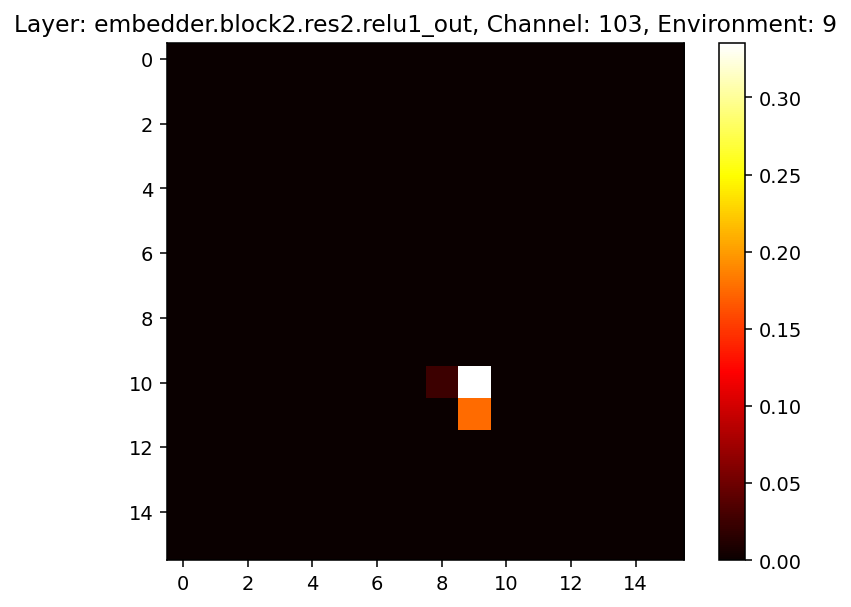

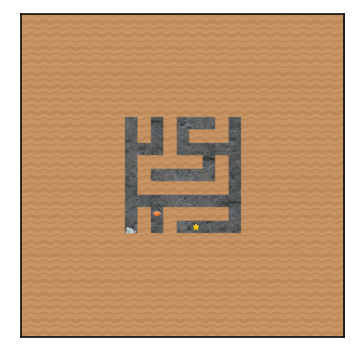

array([[[201, 152, 105],
        [201, 152, 105],
        [201, 152, 105],
        ...,
        [189, 137,  88],
        [201, 152, 105],
        [201, 152, 105]],

       [[201, 152, 105],
        [201, 152, 105],
        [201, 152, 105],
        ...,
        [189, 137,  88],
        [189, 137,  88],
        [189, 137,  88]],

       [[189, 137,  88],
        [189, 137,  88],
        [201, 152, 105],
        ...,
        [189, 137,  88],
        [189, 137,  88],
        [189, 137,  88]],

       ...,

       [[197, 143,  92],
        [197, 143,  92],
        [197, 143,  92],
        ...,
        [201, 152, 105],
        [201, 152, 105],
        [201, 152, 105]],

       [[201, 152, 105],
        [197, 143,  92],
        [197, 143,  92],
        ...,
        [201, 152, 105],
        [201, 152, 105],
        [201, 152, 105]],

       [[201, 152, 105],
        [201, 152, 105],
        [201, 152, 105],
        ...,
        [201, 152, 105],
        [201, 152, 105],
        [201, 152, 105]]

In [ ]:
# activations = visualization.get_activations()
hook_to_use = hook1
layer_name = 'embedder.block1.res1.relu1_out'
layer_name = value_labels_conv[10]
channel_no = 103
env_no = 9
activations = hook_to_use.values_by_label[layer_name][env_no, channel_no, :, :]
plt.title(f'Layer: {layer_name}, Channel: {channel_no}, Environment: {env_no}')
plt.imshow(activations, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
visualization.visualize_venv(venv, env_no, show_plot=True)

In [ ]:
# def linear_probe_single_channels(hook, value_labels, y, 
#         value_preproc_func=lambda value: value, random_state=None,
#         **regression_kwargs):
#     '''Probe with all individual channels in all specified values taken from the
#     provided hook object.  Wrapper around linear_probe.'''
#     results = []
#     for value_label in tqdm(value_labels):

#         value = hook.get_value_by_label(value_label)

#         for ch_ind in tqdm(range(value.shape[1])):
#             ch = value[:,ch_ind,:,:]
#             print(value_preproc_func(ch).shape)
#             results_this = cpr.linear_probe(value_preproc_func(ch), y, **regression_kwargs)
#             results_this.update({
#                 'value_label': value_label,
#                 'channel': ch_ind,})
#             results.append(results_this)
            
#     results_df = pd.DataFrame(results).set_index(['value_label', 'channel']).sort_values(
#         'test_score', ascending=False)
#     return results_df
# results = linear_probe_single_channels(hook1, values_to_store[5:6], goal_pos_y, random_state=42)